In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
import utils
import OptimizedDataGenerator as DG

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-09-09 20:42:42.653138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 20:42:42.653218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 20:42:42.654798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 20:42:42.663292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 20:42:43.946668: W tensorflow/compiler/tf2

In [2]:
# compiles model
model=CreateModel((13,21,2),n_filters=5,pool_size=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)

In [4]:
fingerprint = 'c46424cb'
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

In [5]:
print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)
  

Loading model from ./trained_models/model-c46424cb-checkpoints/weights.97-t-9667.50-v-11509.51.hdf5


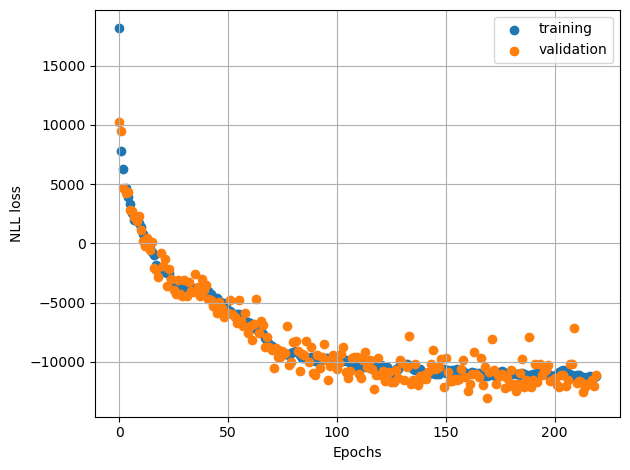

In [6]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.tight_layout() 

plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [7]:
training_history

,epoch,loss,val_loss
0,0,18129.046875,10268.121094
1,1,7829.576660,9450.081055
2,2,6296.990723,4703.739746
3,3,4653.362305,4274.073242
4,4,3925.363770,4355.405762
...,...,...,...
215,215,-11284.954102,-11836.736328
216,216,-11166.067383,-11748.116211
217,217,-11408.896484,-11539.011719
218,218,-11235.523438,-11995.190430


In [8]:
tfrecords_dir_val = "/depot/cms/users/kuang14/Smart_Pixel/tf_records/tfrecords_2t_dataset18_bs5000_val_scaling2"
test_generator = DG.OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
    quantize = True
)

In [9]:
# predicts test data
p_test = model.predict(test_generator)

1028/1028 [==============================] - 143s 139ms/step


In [10]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 1028/1028 [02:10<00:00,  7.89it/s]


In [11]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

In [12]:
# determine the scaling factors 
# in dataset 18 3D case: [385.15, 57.785, 10, 1.14])
sf_x = 385.15
sf_y = 57.785
sf_cotA = 10
sf_cotB = 1.14

# residuals (mean, stdv)

In [13]:
# x
(np.mean(residuals)*sf_x,np.std(residuals)*sf_x)

(-15.033863905631005, 173.80006880760192)

In [14]:
# y
(np.mean(residualsy)*sf_y,np.std(residualsy)*sf_y)

(-1.7454449090827255, 13.77813869819045)

In [15]:
# cotA
(np.mean(residualsA)*sf_cotA,np.std(residualsA)*sf_cotA)

(0.16081597656011581, 1.4053785800933838)

In [16]:
# cotB
(np.mean(residualsB)*sf_cotB,np.std(residualsB)*sf_cotB)

(0.02336120333522558, 0.25686623990535734)

# x residuals

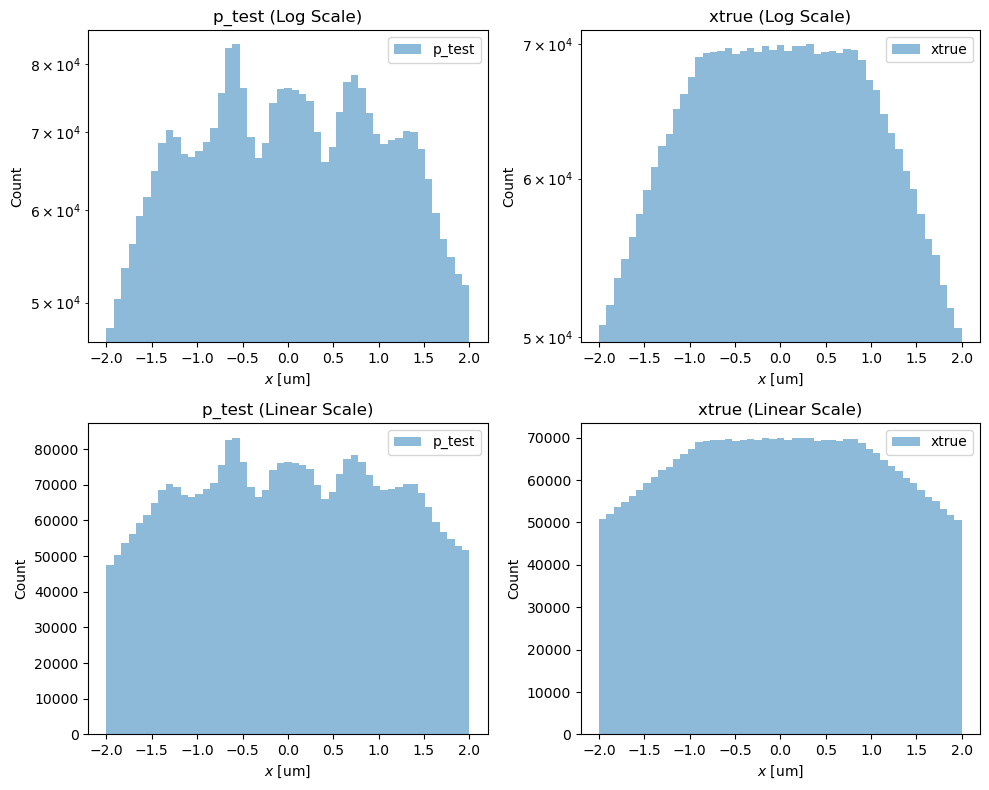

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create the figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First plot: log scale for predicted values (p_test)
axs[0, 0].hist(p_test[:, 0], bins=np.linspace(-2, 2, 50), alpha=0.5, label='p_test')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'$x$ [um]')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()
axs[0, 0].set_title('p_test (Log Scale)')

# Second plot: log scale for true values (xtrue)
axs[0, 1].hist(df['xtrue'], bins=np.linspace(-2, 2, 50), alpha=0.5, label='xtrue')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel(r'$x$ [um]')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()
axs[0, 1].set_title('xtrue (Log Scale)')

# Third plot: linear scale for predicted values (p_test)
axs[1, 0].hist(p_test[:, 0], bins=np.linspace(-2, 2, 50), alpha=0.5, label='p_test')
axs[1, 0].set_xlabel(r'$x$ [um]')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()
axs[1, 0].set_title('p_test (Linear Scale)')

# Fourth plot: linear scale for true values (xtrue)
axs[1, 1].hist(df['xtrue'], bins=np.linspace(-2, 2, 50), alpha=0.5, label='xtrue')
axs[1, 1].set_xlabel(r'$x$ [um]')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()
axs[1, 1].set_title('xtrue (Linear Scale)')

# Adjust the layout
plt.tight_layout()

# Save the figure
save_fig_path = os.path.join(base_dir, 'x_dist_2x2.png')
plt.savefig(save_fig_path)

# Show the plot
plt.show()


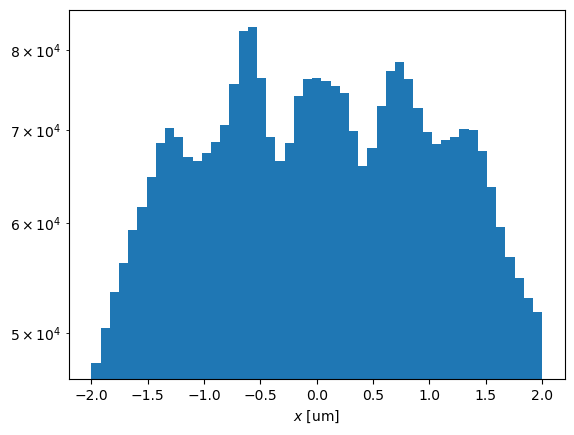

In [18]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

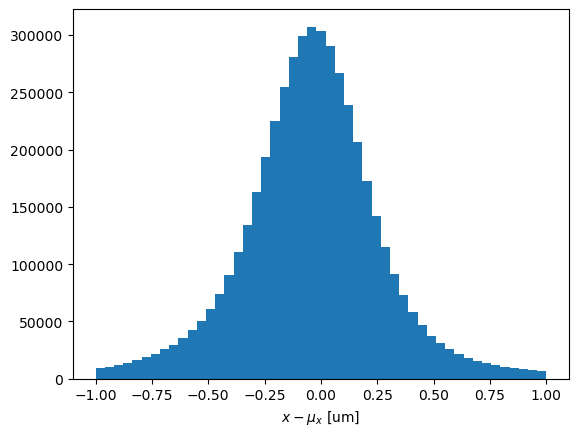

In [19]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

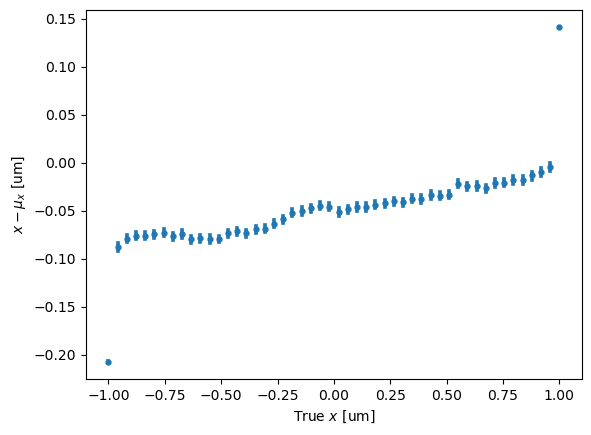

In [20]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

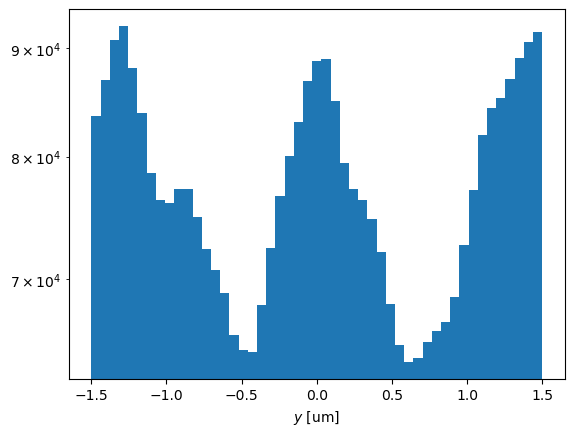

In [21]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

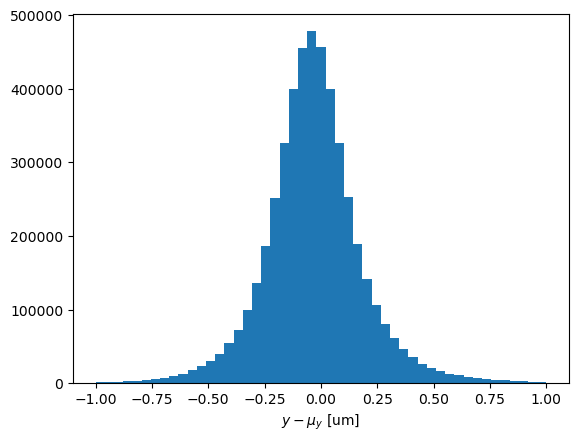

In [22]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

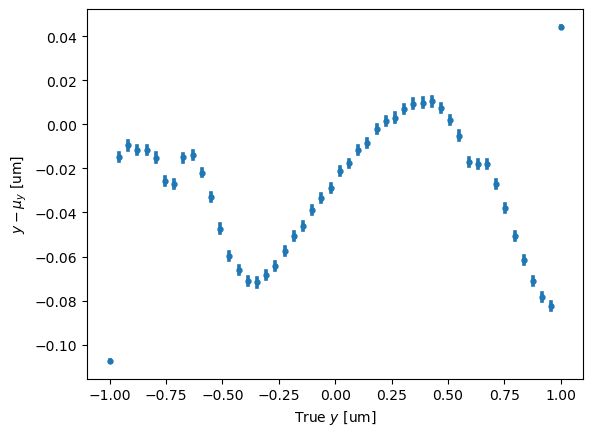

In [23]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

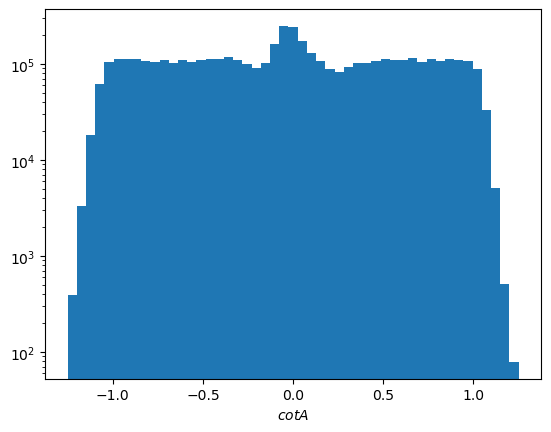

In [24]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

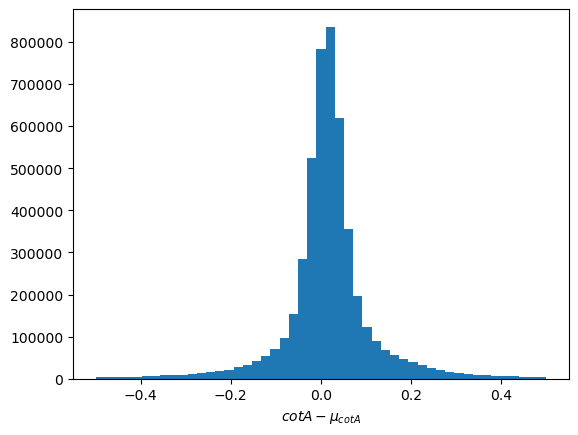

In [25]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

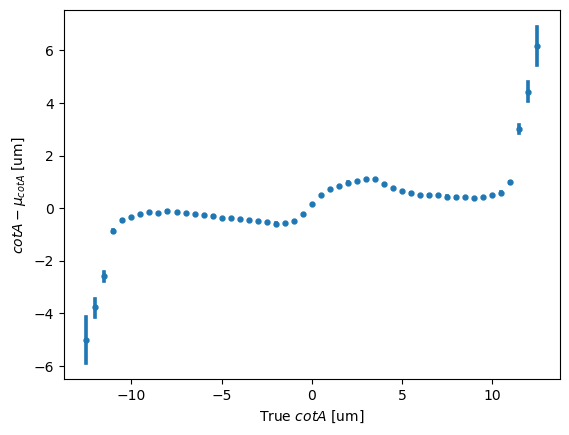

In [26]:
x = sns.regplot(x=df['cotAtrue']*sf_cotA, y=(df['cotAtrue']-df['cotA'])*sf_cotA, x_bins = np.histogram_bin_edges(df['cotAtrue'] * sf_cotA, bins=50)
 , fit_reg=None, marker='.') #x_bins=np.linspace(-8,8,50)
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

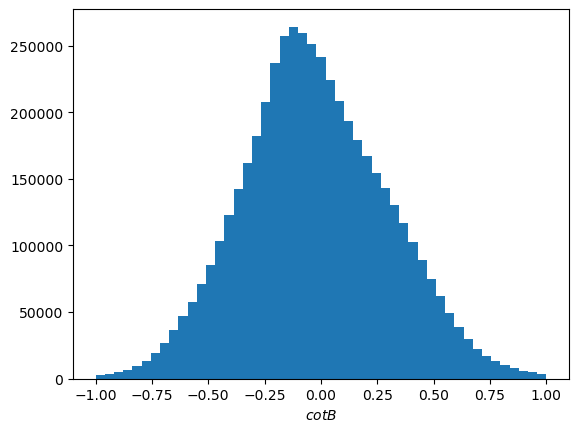

In [27]:
plt.hist(p_test[:,6]*sf_cotB,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

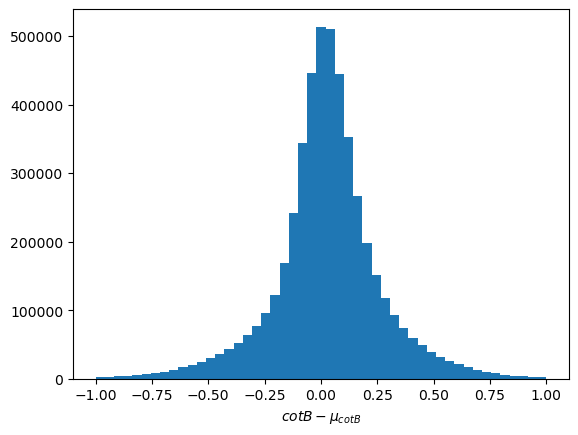

In [28]:
plt.hist(residualsB*sf_cotB,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

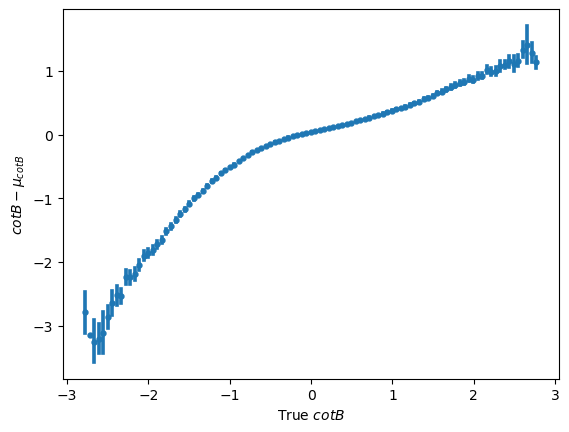

In [29]:
x = sns.regplot(x=df['cotBtrue']*sf_cotB, y=(df['cotBtrue']-df['cotB'])*sf_cotB, x_bins = np.histogram_bin_edges(df['cotBtrue']*sf_cotB, bins=100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [30]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

/tmp/ipykernel_2880388/767124036.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


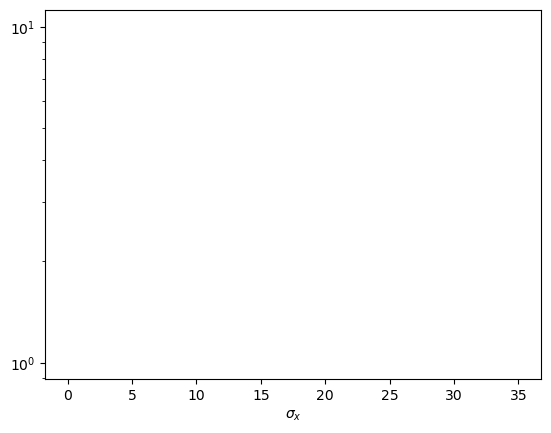

In [31]:
plt.hist(df['sigmax'] * sf_x,bins=np.linspace(0,35,50))
plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

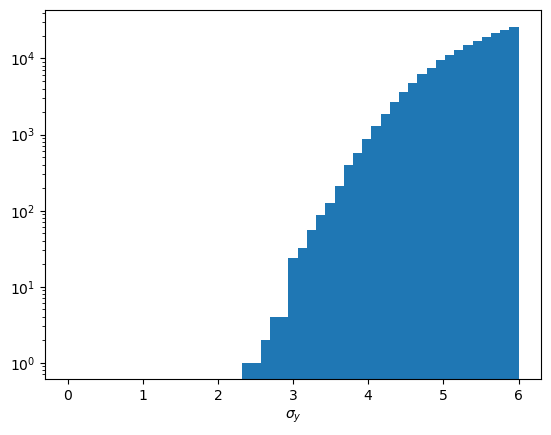

In [32]:
plt.hist(df['sigmay']* sf_y,bins=np.linspace(0,6,50))
plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

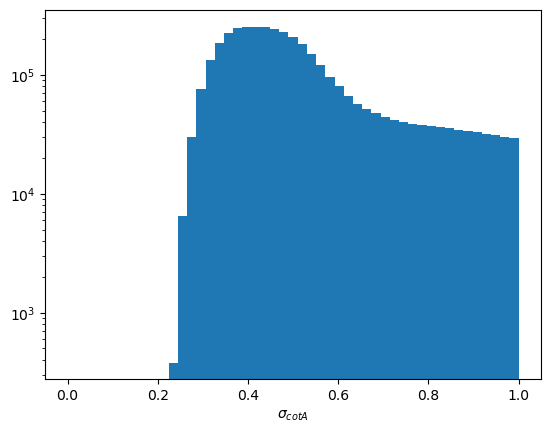

In [33]:
plt.hist(df['sigmacotA'] * sf_cotA,bins=np.linspace(0,1.0,50))
plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

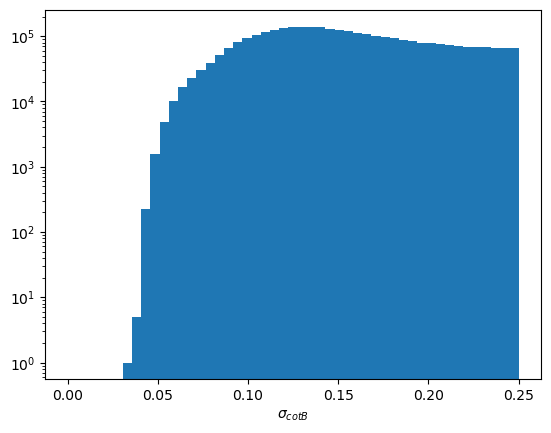

In [34]:
plt.hist(df['sigmacotB'] * sf_cotB ,bins=np.linspace(0,0.25,50))
plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [35]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,2000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,1000,"$\sigma$="+str(round(abs(pars[2]),2)))

Mean -0.19075941090575763
Sigma 0.9933744907464577
Mean -0.2611561877501423
Sigma 0.9440389509876213
Mean 0.25030511590388055
Sigma 0.8799689202958433
Mean 0.13859630759333108
Sigma -0.913460635868479


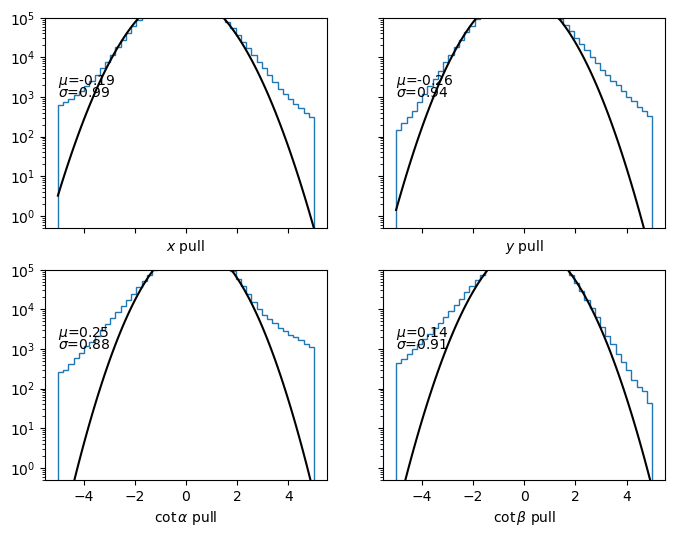

In [36]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [37]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue


/tmp/ipykernel_2880388/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_2880388/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


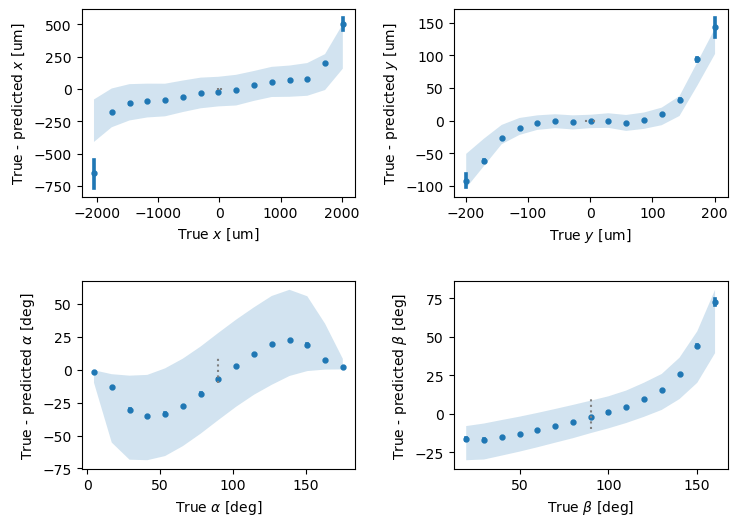

In [38]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=sf_x)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=sf_y)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=sf_cotA)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=sf_cotB)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)